In [2]:
import pandas
import numpy as np
from matplotlib import pyplot as plt

from ipywidgets import interact

# Prepare and merge

In [3]:
df_dep = pandas.read_csv('../data/dpt2018.csv', sep=';', encoding='utf8', na_values=['XXXX', 'XX'])


In [4]:
df_origin = pandas.read_csv('../data/Prenoms.csv', sep=';', encoding='latin1')

In [5]:
df_dep['prenom'] = (df_dep.preusuel.str.lower().str.normalize('NFKD')
                            .str.encode('ascii', errors='ignore')
                            .str.decode('utf-8'))

In [6]:
df_origin.rename(columns={'01_prenom':'prenom', '03_langage':'langage'}, inplace=True)
df_origin.drop(columns=['02_genre', '04_fréquence'])
df_origin.head()

,prenom,02_genre,langage,04_fréquence
0,aaliyah,f,english (modern),0.0
1,aapeli,m,finnish,0.0
2,aapo,m,finnish,0.0
3,aaren,"m,f",english,0.0
4,aarne,m,finnish,0.0


In [7]:
df_merged = df_dep.merge(df_origin, on='prenom', how='inner')

In [8]:
df_dep.preusuel.nunique(), df_dep.prenom.nunique(), df_origin.prenom.nunique(), df_merged.prenom.nunique()

(33483, 30832, 11626, 5067)

## Tendance temporelle

In [9]:
df_merged.assign(decade = df_merged.annais // 10 * 10)

,sexe,preusuel,annais,dpt,nombre,prenom,02_genre,langage,04_fréquence,decade
0,1,AARON,1962.0,75.0,3,aaron,m,"english, biblical",1.37,1960.0
1,1,AARON,1976.0,75.0,3,aaron,m,"english, biblical",1.37,1970.0
2,1,AARON,1982.0,75.0,3,aaron,m,"english, biblical",1.37,1980.0
3,1,AARON,1984.0,75.0,3,aaron,m,"english, biblical",1.37,1980.0
4,1,AARON,1985.0,75.0,5,aaron,m,"english, biblical",1.37,1980.0
...,...,...,...,...,...,...,...,...,...,...
2381776,2,ZUZANNA,2013.0,75.0,3,zuzanna,f,polish,0.00,2010.0
2381777,2,ZUZANNA,2015.0,75.0,4,zuzanna,f,polish,0.00,2010.0
2381778,2,ZUZANNA,2015.0,94.0,3,zuzanna,f,polish,0.00,2010.0
2381779,2,ZUZANNA,2018.0,75.0,4,zuzanna,f,polish,0.00,2010.0


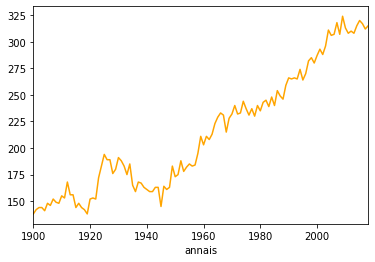

In [10]:
df_merged.groupby('annais').langage.nunique().plot(color="orange")

nombre de prenom francais / vs nombre total par an 

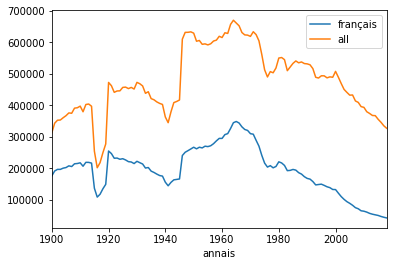

In [11]:
fig, ax = plt.subplots()

(df_merged.dropna().loc[
    df_merged.dropna().langage == 'french']
     .groupby('annais').nombre.sum().plot(ax=ax, label='français'))

(df_merged.dropna().groupby('annais').nombre.sum().plot(ax=ax, label='all'))

plt.legend()
plt.show()

In [12]:
a = df_merged.dropna().groupby('langage').annais.max().values
b = df_merged.dropna().groupby('langage').annais.min().values
c = df_merged.dropna().groupby('langage').annais.keys

/home/campus-9/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


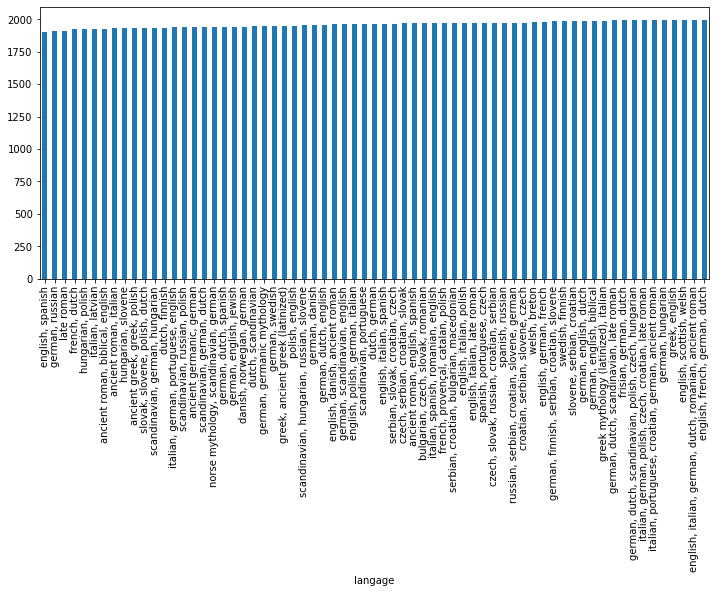

In [13]:
(df_merged.groupby('langage')
          .annais.max()[
              df_merged.groupby('langage')
                .annais.max().values < 1998]
          .sort_values()
          .plot(kind='bar', figsize=(12, 5)))

## spanish Folium

In [215]:
import folium
from folium.plugins import HeatMap
from ipywidgets import interact
import pickle

dpts = pickle.load(open("dico_adress.pkl","rb"))

In [346]:
espagnols = df_merged.dropna().loc[df_merged.dropna().langage == 'dutch']
espagnols_nb = espagnols.groupby(['annais', 'dpt']).nombre.sum()

In [347]:
years = sorted(espagnols.annais.unique())

def f(i):
    
    print(years[i])
    print(espagnols[espagnols.annais == years[i]]
          .groupby('prenom').nombre.sum().sort_values(ascending=False)[:5])
    
    fig, ax = plt.subplots(figsize=(7, 2))
    plt.title('Over time')
    espagnols.groupby('annais').nombre.sum().plot(ax=ax)
    ax.axvline(years[i], ls='--', lw=3, c='gray')
    plt.show()
    
    data = np.array([(*dpts[k],v) for k, v in espagnols_nb[years[i]].items()])
    
    centre = [46.227638, 2.213749]
    m = folium.Map(centre, zoom_start=5)
    HeatMap(data, radius=40, blur=30).add_to(m)
    return m;

In [348]:
interact(f, i=(0, len(years) - 1));

interactive(children=(IntSlider(value=46, description='i', max=92), Output()), _dom_classes=('widget-interact'…

## Bretons et nom bretons

In [260]:
bretagne = [22., 29., 35., 56.]
bretons = df_merged.dropna().loc[df_merged.dropna().dpt.isin(bretagne)]

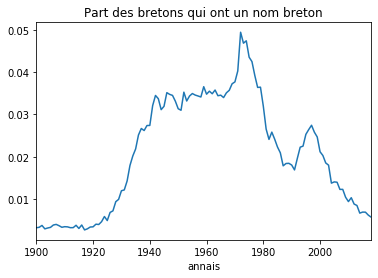

In [291]:
bretons[bretons.langage.str.contains('breton')].groupby(['annais']).nombre.sum().divide(
            bretons.groupby(['annais']).nombre.sum()).plot()
plt.title('Part des bretons qui ont un nom breton')
plt.show()

In [312]:
df_merged.langage.unique()

array(['english, biblical', 'arabic',
       'english, french, spanish, biblical', 'biblical',
       'english, jewish, biblical', 'english', 'french, italian',
       'greek mythology (latinized)', 'german',
       'ancient germanic, german',
       'english, french, german, polish, russian, romanian, biblical',
       'italian', 'turkish', nan, 'jewish', 'indian', 'italian, spanish',
       'french', 'theology', 'greek mythology', 'dutch',
       'english, romanian, russian', 'portuguese',
       'french, german, greek, ancient greek', 'ancient greek',
       'english, german, dutch, scandinavian', 'chinese',
       'irish, scottish', 'spanish', 'english, scottish', 'basque',
       'russian', 'japanese', 'danish, norwegian', 'history', 'scottish',
       'english, german', 'english, french',
       'italian, spanish, portuguese',
       'bulgarian, macedonian, croatian, serbian',
       'polish, slovene, albanian', 'finnish', 'czech',
       'english, german, dutch',
       'german,